In [24]:
import gc
import cv2
import copy
import math
import torch
import os, sys
import numpy as np
import torchvision
import pandas as pd
import torch.nn as nn
from glob import glob
from pathlib import Path
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from seaborn import color_palette
from __future__ import print_function, division
from torchvision import models, transforms, utils

%matplotlib inline

In [25]:
# Helper functions


int_ = lambda x: int(round(x))


def IoU( r1, r2 ):
    x11, y11, w1, h1 = r1
    x21, y21, w2, h2 = r2
    x12 = x11 + w1; y12 = y11 + h1
    x22 = x21 + w2; y22 = y21 + h2
    x_overlap = max(0, min(x12,x22) - max(x11,x21) )
    y_overlap = max(0, min(y12,y22) - max(y11,y21) )
    I = 1. * x_overlap * y_overlap
    U = (y12-y11)*(x12-x11) + (y22-y21)*(x22-x21) - I
    J = I/U
    return J


def evaluate_iou( rect_gt, rect_pred ):
    score = [ IoU(i, j) for i, j in zip(rect_gt, rect_pred) ]
    return score


def compute_score( x, w, h ):
    k = np.ones( (h, w) )
    score = cv2.filter2D(x, -1, k)
    score[:, :w//2] = 0
    score[:, math.ceil(-w/2):] = 0
    score[:h//2, :] = 0
    score[math.ceil(-h/2):, :] = 0
    return score


def locate_bbox( a, w, h ):
    row = np.argmax( np.max(a, axis=1) )
    col = np.argmax( np.max(a, axis=0) )
    x = col - 1. * w / 2
    y = row - 1. * h / 2
    return x, y, w, h


def score2curve( score, thres_delta = 0.01 ):
    thres = np.linspace( 0, 1, int(1./thres_delta)+1 )
    success_num = []
    for th in thres:
        success_num.append( np.sum(score >= (th+1e-6)) )
    success_rate = np.array(success_num) / len(score)
    return thres, success_rate


def all_sample_iou( score_list, gt_list):
    num_samples = len(score_list)
    iou_list = []
    for idx in range(num_samples):
        score, image_gt = score_list[idx], gt_list[idx]
        w, h = image_gt[2:]
        pred_rect = locate_bbox( score, w, h )
        iou = IoU( image_gt, pred_rect )
        iou_list.append( iou )
    return iou_list


def plot_success_curve( iou_score, title='' ):
    thres, success_rate = score2curve( iou_score, thres_delta = 0.05 )
    auc_ = np.mean( success_rate[:-1] )
    plt.figure()
    plt.grid(True)
    plt.xticks(np.linspace(0,1,11))
    plt.yticks(np.linspace(0,1,11))
    plt.ylim(0, 1)
    plt.title(title + 'auc={}'.format(auc_))
    plt.plot( thres, success_rate )
    plt.show()

In [26]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, template_dir_path, image_name, transform=None):
        self.transform = transform

        if not self.transform:
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
            ])

        self.template_path = list(template_dir_path.iterdir())
        self.image_name = image_name

        self.image_raw = cv2.imread(self.image_name)

        if self.transform:
            self.image = self.transform(self.image_raw).unsqueeze(0)

    def __len__(self):
        return len(self.template_names)

    def __getitem__(self, idx):
        '''

        extract template path, read the template, apply transformation if provided

        '''
        template_path = self.template_path[idx]
        template_raw = cv2.imread(str(template_path))
        template_raw = cv2.cvtColor(template_raw, cv2.COLOR_BGR2RGB)
        template = self.transform(template_raw)
        thresh = 0.7
        return {'image': self.image,
                    'image_raw': self.image_raw,
                    'image_name': self.image_name,
                    'template': template.unsqueeze(0),
                    'template_name': template_path,
                    'template_h': template.size()[-2],
                   'template_w': template.size()[-1],
                   'thresh': thresh}

In [27]:
template_dir = './template'
image_path = './sample/sample1.jpg'
dataset = ImageDataset(Path(template_dir), image_path)

In [28]:
class Featex():
    def __init__(self, model, use_cuda):

        self.use_cuda = use_cuda
        self.feature1 = None
        self.feature2 = None

        self.model = copy.deepcopy(model).eval() # Deepcopy input model in eval mode

        if isinstance(self.model, nn.Sequential):
            self.model = nn.Sequential(*list(self.model.children())[:17])
        else:
            # Handles case where model.features exists (e.g., torchvision.models.vgg16)
            self.model = nn.Sequential(*list(self.model.features.children())[:17])

        # Freeze the model
        for param in self.model.parameters():
            param.requires_grad = False

        if self.use_cuda:
            self.model = self.model.cuda()

        self.model[2].register_forward_hook(self.save_feature1)
        self.model[16].register_forward_hook(self.save_feature2)

    def save_feature1(self, module, input, output):
        self.feature1 = output.detach()

    def save_feature2(self, module, input, output):
        self.feature2 = output.detach()

    def __call__(self, input, mode='big'):

        if self.use_cuda:
            input = input.cuda()

        _ = self.model(input)

        if mode=='big':
            self.feature1 = F.interpolate(self.feature1, size=(self.feature2.size()[2], self.feature2.size()[3]), mode='bilinear', align_corners=True)
        else:
            self.feature2 = F.interpolate(self.feature2, size=(self.feature1.size()[2], self.feature1.size()[3]), mode='bilinear', align_corners=True)

        return torch.cat((self.feature1, self.feature2), dim=1)

In [29]:
class MyNormLayer():
    def __call__(self, x1, x2):
        bs, _ , H, W = x1.size()
        _, _, h, w = x2.size()
        eps = 1e-12
        x1 = x1.view(bs, -1, H*W)
        x2 = x2.view(bs, -1, h*w)
        concat = torch.cat((x1, x2), dim=2)
        x_mean = torch.mean(concat, dim=2, keepdim=True)
        x_std = torch.std(concat, dim=2, keepdim=True)
        x1 = (x1 - x_mean) / (x_std + eps)
        x2 = (x2 - x_mean) / (x_std + eps)
        x1 = x1.view(bs, -1, H, W)
        x2 = x2.view(bs, -1, h, w)
        return [x1, x2]

In [30]:
class Conf_calculator():
    def __init__(self, alpha):
        self.alpha = alpha

    def __call__(self, x):

        batch_size, ref_row, ref_col, qry_row, qry_col = x.size()

        x = x.view(batch_size, ref_row*ref_col, qry_row*qry_col)
        xm_ref = x - torch.max(x, dim=1, keepdim=True)[0]
        xm_qry = x - torch.max(x, dim=2, keepdim=True)[0]

        confidence = torch.sqrt(F.softmax(self.alpha*xm_ref, dim=1) * F.softmax(self.alpha * xm_qry, dim=2))

        conf_values, ind3 = torch.topk(confidence, 1)

        ind1, ind2 = torch.meshgrid(torch.arange(batch_size), torch.arange(ref_row*ref_col))

        ind1 = ind1.flatten()
        ind2 = ind2.flatten()
        ind3 = ind3.flatten()
        if x.is_cuda:
            ind1 = ind1.cuda()
            ind2 = ind2.cuda()

        values = confidence[ind1, ind2, ind3]
        values = torch.reshape(values, [batch_size, ref_row, ref_col, 1])
        return values

    def compute_output_shape( self, input_shape ):
        bs, H, W, _, _ = input_shape
        return (bs, H, W, 1)

In [31]:
class CreateModel():
    def __init__(self, alpha, model, use_cuda):

        self.alpha = alpha
        self.featex = Featex(model, use_cuda)
        self.I_feat = None
        self.I_feat_name = None

    def __call__(self, template, image, image_name):

        T_feat = self.featex(template)
        if self.I_feat_name is not image_name:
            self.I_feat = self.featex(image)
            self.I_feat_name = image_name
        conf_maps = None
        batchsize_T = T_feat.size()[0]

        for i in range(batchsize_T):
            T_feat_i = T_feat[i].unsqueeze(0)
            I_feat_norm, T_feat_i = MyNormLayer()(self.I_feat, T_feat_i)
            dist = torch.einsum("xcab,xcde->xabde", I_feat_norm / torch.norm(I_feat_norm, dim=1, keepdim=True), T_feat_i / torch.norm(T_feat_i, dim=1, keepdim=True))
            conf_map = Conf_calculator(self.alpha)(dist)
            if conf_maps is None:
                conf_maps = conf_map
            else:
                conf_maps = torch.cat([conf_maps, conf_map], dim=0)

        return conf_maps

In [32]:
def nms_multi(scores, w_array, h_array, thresh_list):
    indices = np.arange(scores.shape[0])
    maxes = np.max(scores.reshape(scores.shape[0], -1), axis=1)
    scores_omit = scores[maxes > 0.1 * maxes.max()]
    indices_omit = indices[maxes > 0.1 * maxes.max()]
    dots = None
    dos_indices = None
    for index, score in zip(indices_omit, scores_omit):
        dot = np.array(np.where(score > thresh_list[index]*score.max()))
        if dots is None:
            dots = dot
            dots_indices = np.ones(dot.shape[-1]) * index
        else:
            dots = np.concatenate([dots, dot], axis=1)
            dots_indices = np.concatenate([dots_indices, np.ones(dot.shape[-1]) * index], axis=0)
    dots_indices = dots_indices.astype(int)
    x1 = dots[1] - w_array[dots_indices]//2
    x2 = x1 + w_array[dots_indices]
    y1 = dots[0] - h_array[dots_indices]//2
    y2 = y1 + h_array[dots_indices]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    scores = scores[dots_indices, dots[0], dots[1]]
    order = scores.argsort()[::-1]
    dots_indices = dots_indices[order]

    keep = []
    keep_index = []
    while order.size > 0:
        i = order[0]
        index = dots_indices[0]
        keep.append(i)
        keep_index.append(index)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= 0.05)[0]
        order = order[inds + 1]
        dots_indices = dots_indices[inds + 1]

    boxes = np.array([[x1[keep], y1[keep]], [x2[keep], y2[keep]]]).transpose(2,0,1)
    return boxes, np.array(keep_index)


In [33]:
def plot_result(image_raw, boxes, show=False, save_name=None, color=(255, 0, 0)):
    d_img = image_raw.copy()
    for box in boxes:
        d_img = cv2.rectangle(d_img, tuple(box[0]), tuple(box[1]), color, 3)
    if show:
        plt.imshow(d_img[:,:,::-1])
    if save_name:
        cv2.imwrite(save_name, d_img)
    return d_img

In [34]:
def plot_result_multi(image_raw, boxes, indices, show=False, save_name=None, color_list=None):
    d_img = image_raw.copy()
    if color_list is None:
        color_list = color_palette("hls", indices.max()+1)
        color_list = list(map(lambda x: (int(x[0]*255), int(x[1]*255), int(x[2]*255)), color_list))
    for i in range(len(indices)):
        d_img = plot_result(d_img, boxes[i][None, :,:].copy(), color=color_list[indices[i]])
    if show:
        plt.imshow(d_img[:,:,::-1])
    if save_name:
        cv2.imwrite(save_name, d_img)
    return d_img

In [35]:
def run_one_sample(model, template, image, image_name):
    val = model(template, image, image_name)
    if val.is_cuda:
        val = val.cpu()
    val = val.numpy()
    val = np.log(val)

    batch_size = val.shape[0]
    scores = []
    for i in range(batch_size):
        gray = val[i,:,:,0]
        gray = cv2.resize( gray, (image.size()[-1], image.size()[-2]) )
        h = template.size()[-2]
        w = template.size()[-1]
        score = compute_score( gray, w, h)
        score[score>-1e-7] = score.min()
        score = np.exp(score / (h*w))
        scores.append(score)
    return np.array(scores)


In [36]:
def run_multi_sample(model, dataset):
    scores = []
    w_array = []
    h_array = []
    thresh_list = []
    for data in dataset:
        score = run_one_sample(model, data['template'], data['image'], data['image_name'])
        scores.append(score)

        w_array.append(data['template_w'])
        h_array.append(data['template_h'])
        thresh_list.append(data['thresh'])
    return np.squeeze(np.array(scores), axis=1), np.array(w_array), np.array(h_array), thresh_list

In [37]:
vgg19 = models.vgg19(pretrained=True)
model = CreateModel(model=vgg19, alpha=25, use_cuda=True) # Get features of pre-trained VGG19 model

In [38]:
scores, w_array, h_array, thresh_list = run_multi_sample(model, dataset)

/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [39]:
boxes, indices = nms_multi(scores, w_array, h_array, thresh_list)

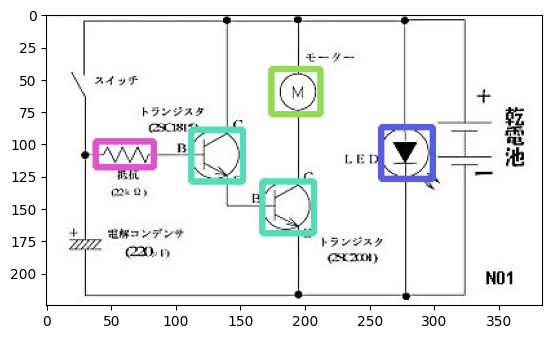

In [40]:
d_img = plot_result_multi(dataset.image_raw, boxes, indices, show=True, save_name='result_sample.png')

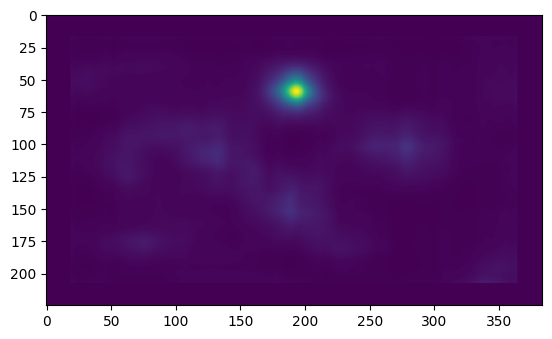

In [42]:
plt.imshow(scores[2])